# Un exemple complet

Nous allons, à travers un exemple montrer l'étude complète, du protocole à l'exploitation, comment utiliser Python pour estimer les incertitudes, ajuster une loi affine et exploiter les résultats obtenus.

## Protocole
* __Objectif__ : On désire tester la loi de Mariotte qui relie Pression, Volume et Température d'un gaz : $PV = nRT$ pour l'air dans les conditions de température ambiante et de pression de quelques centaines d'hectoPascal. On déterminera aussi le nomber de mole d'air du système étudié.
* __Principe__ : On va procéder à la mesure de couples $(P, V)$ pour plusieurs valeurs de $V$ à la température ambiante et on testera la loi $P(V)$ ainsi obtenue. Le modèle ajusté obtenu permettra de déterminer $n$.
* __Mode opératoire__ : On va utiliser [une seringue](mariotte_photo) contenant de l'air pour controler le volume. L'embout de la seringue sera branché sur un manomètre. Ce manomètre mesure une pression et renvoie une tension $U$ qu'on mesure grâce à un microcontrolleur Arduino programmé pour renvoyer les mesures vers un système de traitement informatique.  
```{margin}
Donnez bien la relation qui doit être une droite (ici $P = f(1/V)$)
```
Grâce à la seringue, on va imposer un volume $V$ d'air et on mesure grâce au manomètre la pression $P$. On réalisera plusieurs mesures successives de $P$ pour différents volumes imposés $V$. On testera alors la relation $P = f(1/V)$ pour vérifier qu'il s'agit d'une droite.  
En mesurant la température grâce à un thermomètre, on utilisera le coefficient $nRT$ de la droite ajustée sur la relation $P=f(1/V)$ pour déterminer le nombre de mole d'air emprisonné.

```{margin}
Le schéma suffirait dans un compte-rendu.
```
`````{grid}
````{grid-item}
```{figure} ./images/mariotte.png
:name: mariotte_photo
:align: center
Photo du montage
```
````
````{grid-item}
```{figure} ./images/mariotte_montage.png
:name: mariotte_montage
:align: center
Schéma du montage
```
````
`````


## Analyse des sources d'incertitudes
On veut tester une relation, il faudra bien réfléchir aux incertitudes. __Elle a été faite durant la mesure.__

### Mesurandes directs
On dispose de trois mesurandes directs :
* la température $T$ mesurée par un thermomètre numérique dont le constructeur annonce une _tolérance_ de 5% sur la mesure en Celsius. On considèrera qu'il s'agit d'une incertitude-type (associé à une distribution uniforme). Cette source étant grande devant la résolution de l'affichage (1/10 de degré pour des températures d'environ 30°C), on considèrera qu'il s'agit de la seule source.
* le volume $V$. Il y a deux sources d'incertitudes :
	* la lecture du volume de la seringue $V_{ser}$ souffre de la précision des graduations. La photo montre que les mesures seront incertaines à 2mL près. On choisira une distribution uniforme de largeur 2mL.
	* On doit corriger $V$ par le volume du petit tuyau $V_{tuyau}$ (identique pour tous les volumes). On a mesuré la longueur du tuyau $L = 4.0 \pm 0.2 cm$ (distribution uniforme) à la règle et son diamètre $d = 1.000 \pm 0.005 mm$ avec un pieds à coulisse micrométrique électronique. Vu la faible incertitude __relative ET absolue__ sur $d$, on la négligera par la suite.
	* Le volume total est donné par $V = V_{ser} + V_{tuyau}= V_{ser} + \pi d^2 L / 4$

```{margin}
En toute rigueur, $V_{ser}$ et $V_{tuyau}$ sont des mesurandes directs et $V$ un mesurande indirect. En pratique, on considère souvent que $V_{tuyau}$ est une __correction__ du mesurande direct $V$. Mais la première vision n'est pas fausse.
```

* la tension $U$ délivrée par Arduino. Il y a deux sources d'incertitude:
	* la valeur renvoyée fluctue au cours du temps, on n'a uniquement pu mesurer des intervalles $[U_{min}, U_{max}]$ de valeurs (autour de $10^{-2}V$). On associera à ces intervalles une distribution uniforme.
	* la valeur renvoyé (entre 0 et 5V) est codée numérique entre 0 et 1023 bits. Il y a donc une résolution de $5 / 1023 = 0.0049 V$. Elle est cependant négligeable devant l'incertitude liée aux fluctuations.

```{note} 
On sera souvent amené à considérer certaines sources d'incertitude comme négligeable. Il est important de réfléchir aux ordres de grandeurs de ces sources.

Cette réflexion est importante et doit se faire assez tôt pour savoir quelles incertitudes prendre en compte.
```

### Mesurandes indirects
Les mesurandes indirects sont la pression $P$ et $1/V$.
* L'étalonnage du manomètre donne la relation $P(hPa) = 218.5 U(V) - 107.3$ avec des incertitudes sur les coefficients négligeables devant l'incertitude sur $U$.

## Résultats de mesure.

La mesure de la température donne $T = 30.1 \pm 1.5 °C$.

On ne donne que les résultats de mesure bruts : $V_{ser}, U_{min}, U_{max}$ et $T$. L'estimation des autres grandeurs et de leur incertitude se fera grâce à Python.

In [1]:
import pandas as pd
import numpy as np

Vser = np.array([18, 24, 30, 34, 40, 50, 60])
Umin = np.array([5.67, 4.36, 3.58, 3.22, 2.85, 2.34, 2.02])
Umax = np.array([5.74, 4.46, 3.75, 3.34, 2.91, 2.48, 2.18])

donnees = pd.DataFrame(
    {
        "Vser(mL)": ["{:.0f}".format(val) for val in Vser],
        "Umin(V)": ["{:.2f}".format(val) for val in Umin],
        "Umax(V)": ["{:.2f}".format(val) for val in Umax],
    }
)

donnees.style

,Vser(mL),Umin(V),Umax(V)
0,18,5.67,5.74
1,24,4.36,4.46
2,30,3.58,3.75
3,34,3.22,3.34
4,40,2.85,2.91
5,50,2.34,2.48
6,60,2.02,2.18


### Exploitation des résultats.

Puisqu'on doit estimer les incertitudes de mesures sur $V$ et $P$ pour les tracés, on va réaliser une simulation de Monte-Carlo. On va donc :
* Pour chaque (=boucle) volume d'air, estimer N fois le volume $V$ et la pression $P$ et $1/V$ puis en déduire leurs valeurs mesurées (moyenne) et leur incertitude (écart-type). On stockera toutes les valeurs simulées et on rendra compte dans un tableau des résultats de mesure avec leurs incertitudes.
* Tracer $P=f(1/V)$ avec les croix d'incertitude pour tester la validité de la loi de Mariotte.
* Si la loi de Mariotte est vérifiée, réaliser N ajustements affines à partir des valeurs simulées de $V$ et $P$ pour obtenir une estimation de la pente $nRT$ ainsi que son incertitude. On estimera aussi l'ordonnée à l'origine et son incertitude pour vérifier la validité d'un modèle linéaire et non affine.
* On déduira $n$ de l'estimation de la pente (on prolonge la simulation de Monte-Carlo pour composer l'incertitude sur la pente avec celle sur $T$).

#### Estimation des volumes et pression. 
_Le code est en ligne._
Si vous ne comprendez pas le principe de cette partie, reprendre la [propagation des incertitudes](indirecte).

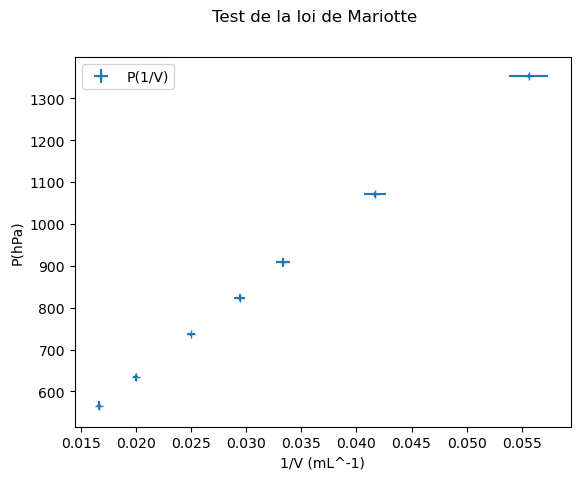

In [2]:
"""
Comme d'habitude, on commence par importer les bibliothèques scientifiques
"""
import numpy as np  # Calcul sur les vecteurs numpy
import numpy.random as rd  # Tirages alératoires
import matplotlib.pyplot as plt  # Tracés graphiques


"""
On rentre les données brutes
"""
L = 4  # Longueur du tuyau (en cm pour obtenir des cm^3 soit des mL)
uL = 0.2  # Incertitude sur L
d = 0.1  # Diamètre

Vser = np.array([18, 24, 30, 34, 40, 50, 60])  # Volume de la seringue
uVser = 1  # Demi-largeur de la distribution

Umin = np.array([5.67, 4.36, 3.58, 3.22, 2.85, 2.34, 2.02])  # Tension min
Umax = np.array([5.74, 4.46, 3.75, 3.34, 2.91, 2.48, 2.18])  # Tension max
Umoy = (Umax + Umin) / 2  # Valeur moyenne des tensions
dU = (Umax - Umin) / 2  # Demi-largeur de la distribution uniforme

"""Coefficient de la relation P = aU + b"""
a = 218.5  
b = 107.3

"""Simulation de Monte-Carlo"""

Vs = []  # On va stocker les vecteurs de valeurs simulées de V dans une liste (une liste de vecteurs donc)
V_moy = []  # On va stocker les valeurs moyennes des volumes
V_inc = []  # On va stocker les écart-types des volumes
invVs = []  # On va stocker les vecteurs de valeurs simulées de 1/V dans une liste (une liste de vecteurs donc)
invV_moy = []  # On va stocker les valeurs moyennes des 1/V
invV_inc = []  # On va stocker les écart-types des 1/V

Ps = []  # On va stocker les vecteurs de valeurs simulées de P dans une liste (une liste de vecteurs donc)
P_moy = []  # On va stocker les valeurs moyennes des pressions
P_inc = []  # On va stocker les écart-types des pressions
Nmes = len(Vser)  # Nombre de mesures réalisées.
N = 10000  # Nombre de simulations

for i in range(Nmes):  # Parcours des valeurs mesurées.
	"""Simulation des valeurs pour estimer les volumes"""
	L_sim = rd.uniform(-uL, uL, N)  # Valeurs simulées de L
	Vser_sim = rd.uniform(-uVser, uVser, N) + Vser[i]  # Valeurs simulées de Vser

	V_sim = Vser_sim + np.pi * d ** 2 / 4 * L_sim  # Calcul des valeurs simulées de V
	Vs.append(V_sim)  # Ajout des valeurs au tableau Vs
	V_moy.append(np.mean(V_sim))  # Ajout de la moyenne de V
	V_inc.append(np.std(V_sim, ddof=1))  # Ajout de l'écart-type de V
	
	"""Estimation des 1/V"""
	invV_sim = 1 / V_sim  # Calcul des valeurs simulées de 1/V
	invVs.append(invV_sim)  # Ajout des valeurs au tableau invVs
	invV_moy.append(np.mean(invV_sim))  # Ajout de la moyenne de 1/V
	invV_inc.append(np.std(invV_sim, ddof=1))  # Ajout de l'écart-type de 1/V

	"""Estimation des pressions"""
	U_sim = rd.uniform(-dU[i], dU[i], N) + Umoy[i]  # Calcul des valeurs simulées de U
	P_sim = a * U_sim + b  #Calcul des valeurs simulées de P
	Ps.append(P_sim)  # Ajout des valeurs au tableau Ps
	P_moy.append(np.mean(P_sim))  # Ajout de la moyenne de P
	P_inc.append(np.std(P_sim, ddof=1))  # Ajout de l'écart-type de P

"""Tracé de P=f(1/V)"""
f, ax = plt.subplots()
f.suptitle("Test de la loi de Mariotte")
ax.set_xlabel("1/V (mL^-1)")
ax.set_ylabel("P(hPa)")

ax.errorbar(invV_moy, P_moy, xerr=invV_inc, yerr=P_inc, label="P(1/V)", marker='+', linestyle='') # Tracé sans relier les points

ax.legend()
plt.show()

On observe que le tracé $P = f(1/V)$ est visuellement cohérent avec une relation linéaire (au moins affine). On va donc poursuivre l'étude avec un ajustement par un modèle affine. Avant, on rend compte des résultats de mesure (en pratique, il faudrait mieux arrondir mais l'affichage par Python a ici ses limites : quelques valeurs pour les incertitudes de 1/V et P ont 3 chiffres significatifs au lieu de 2). _Pour des valeurs intermédiaires, ce n'est pas trop critique_.

In [3]:
def get_rang(inc):
	return int(-(np.ceil(np.log10(inc)) - 2))


def get_aff(mes, inc):
	nmes = len(mes)
	return [round(mes[i], get_rang(inc[i])) for i in range(nmes)]

P_aff = get_aff(P_moy,P_inc)
V_aff = get_aff(V_moy,V_inc)
invV_aff = get_aff(invV_moy,invV_inc)

uP_aff = get_aff(P_inc,P_inc)
uV_aff = get_aff(V_inc,V_inc)
uinvV_aff = get_aff(invV_inc,invV_inc)

donnees2 = pd.DataFrame(
    {
        "V(mL)": ["{:.2f}".format(x) for x in V_aff],
        "u(V)(mL)": ["{:.2f}".format(x) for x in uV_aff],
        "1/V(mL^-1)": ["{:.5f}".format(x) for x in invV_aff],
        "u(1/V)(mL^-1)": ["{:.5f}".format(x) for x in uinvV_aff],
        "P(hPa)": ["{:.1f}".format(x) for x in P_aff],
        "u(P)(hPa)": ["{:.1f}".format(x) for x in uP_aff],
    }
)

donnees2.style

,V(mL),u(V)(mL),1/V(mL^-1),u(1/V)(mL^-1),P(hPa),u(P)(hPa)
0,18.00,0.58,0.05560,0.00180,1353.8,4.4
1,24.01,0.57,0.04168,0.00100,1070.9,6.3
2,30.00,0.57,0.03334,0.00064,908.0,11.0
3,34.01,0.58,0.02941,0.00050,824.1,7.6
4,40.00,0.58,0.02501,0.00036,736.6,3.8
5,50.01,0.58,0.02000,0.00023,633.8,8.8
6,60.00,0.58,0.01667,0.00016,566.0,10.0


#### Ajustement linéaire
Si vous ne comprendez pas le principe la suite, reprendre [l'ajustement linéaire](regression).

---------------------------------------
L'ordonnée à l'origine est 231 +/- 22 hPa
---------------------------------------


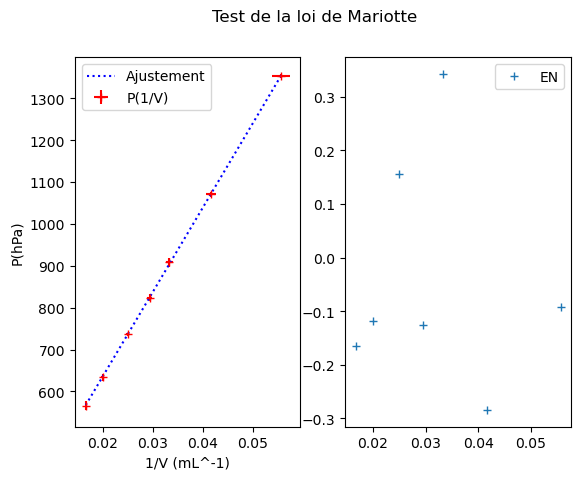

In [4]:
"""On réalise maintenant l'ajustement linéaire pour chaque groupe d'échantillons simulés."""
nRTs = []  # On va stocker les pentes
ordo = []  # On av stocker les ordonnées à l'origine
for i in range(N):
	invV = [x[i] for x in invVs]  # On utilise la compréhension de liste pour sélectionner le ième élément pour chaque volume.
	P = [x[i] for x in Ps]  # On utilise la compréhension de liste pour sélectionner le ième élément pour chaque pression.
	par = np.polyfit(invV, P, 1)  # Régression linéaire
	nRTs.append(par[0])  # Stockage de la pente
	ordo.append(par[1])  # Stockage de l'ordonnée à l'origine

"""Calcul de la moyenne et écart-type"""
nRT_moy = np.mean(nRTs)  # Moyenne (Estimation de nRT)
nRT_inc = np.std(nRTs, ddof=1)  # Ecart-type (Estimation de l'incertitude sur nRT)
ordo_moy = np.mean(ordo)
ordo_inc = np.std(ordo, ddof=1)

print("---------------------------------------")
print("L'ordonnée à l'origine est {:.0f} +/- {:.0f} hPa".format(ordo_moy, ordo_inc))
print("---------------------------------------")

P_adj = nRT_moy * np.array(invV_moy) + ordo_moy  # Estimation des valeurs ajustées pour le tracé
"""Remarque : On doit transformer invV_moy en un vecteur numpy pour appliquer une opération à chaque élément."""
en = (P_moy - P_adj) / P_inc  # Ecarts normalisés

"""Tracé de P=f(1/V)"""
f, ax = plt.subplots(1, 2)  # On trace deux graphiques : P(1/V) avec le modèle ajusté et les écarts normalisés
f.suptitle("Test de la loi de Mariotte")
ax[0].set_xlabel("1/V (mL^-1)")
ax[0].set_ylabel("P(hPa)")

"""Comparaison graphique entre les points de mesure et le modèle ajusté"""
ax[0].errorbar(invV_moy, P_moy, xerr=invV_inc, yerr=P_inc, label="P(1/V)", marker='+', linestyle='', color='red') # Tracé sans relier les points
ax[0].plot(invV_moy, P_adj, label="Ajustement", linestyle=':', color='blue') # Tracé sans relier les points
ax[0].legend()

"""Calcul des écarts normalisés"""
ax[1].plot(invV_moy, en, label="EN", marker="+", linestyle='')
ax[1].legend()
plt.show()

On observe que :
* La droite d'ajustement passe par les croix d'incertitude et les écarts normalisés sont tous inférieurs à 2, on peut donc considérer que l'ajustement est compatible avec les données de mesure.
* L'ordonnée à l'origine possède un intervalle qui contient 0 (ou l'écart normalisé à 0 est inférieur à 2) donc on peut considérer que le modèle linéaire est acceptable.

On peut donc conclure que __le modèle de Mariotte est acceptable pour l'air dans les conditions de température et de pression du laboratoire.__

On va donc pouvoir utiliser ces données pour mesurer le nombre de moles.

In [5]:
"""Estimation du nombre de moles.
On réutilise les données simulées pour la pente nRT.
"""
R = 8.314  # Constante des gaz parfaits
T_mes = 30.1
uT = 1.5
T_sim = rd.uniform(-uT, uT, N) + T_mes - 273.5  # On simule T en Kelvin

"""On va modifier les unités :
nRT = PV
- ici P est en hPa : on multiplie par 10^2
- V est en mL : on multiplie par 10^-6
"""
n_sim = nRTs / (R * T_sim) * 1e-4

n_moy = np.mean(n_sim)
n_inc = np.std(n_sim, ddof=1)

print("---------------------------------------")
print("Nombre de mole. n = {:.2e} +/- {:.1e} mol".format(n_moy, n_inc))
print("---------------------------------------")

---------------------------------------
Nombre de mole. n = -9.98e-04 +/- 4.2e-05 mol
---------------------------------------


On n'a pas de valeur attendue pour le nombre de mole et on est dans l'ordre de grandeur attendu vu le volume occupé à pression ambiante.